In [1]:
import gseapy as gp
import pandas as pd
import numpy as np
import scipy.stats as stats
import glob
from biomart import BiomartServer
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import gseapy as gp

from sklearn import decomposition
from sklearn import preprocessing

from scripts import aesthetics

aesthetics.activate_paper_rcParams()

pd.set_option("display.max_columns", 1000)

# Neuroblastoma Process RNA

In this notebook, we'll process the RNA for the neuroblastoma and take a look at some QC metrics.

# Load our data

In [2]:
# define metadata
metadata_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.2.cohort_metadata.w_control_assignments.tsv.gz"
samples_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.2.final_analysis_cohort.samples.list"

In [3]:
# list of genes that are annotated - drop ensembl IDs
gene_ref = pd.read_csv("ref/gencode_hg38_protein_coding_genes_for_annotation_7_31_23.txt")
gene_ref = gene_ref[~gene_ref['value'].str.startswith('ENSG00')]
gene_ref = gene_ref['value'].tolist()

Load metadata and SVs

In [4]:
metadata = pd.read_csv(
    metadata_path,
    sep="\t",
)

# add a sex label to metadata
metadata["sex"] = (metadata["chrX_CopyNumber"].round() < 2).astype(int)

## Read in TPMs

Load our TPMs. We'll briefly take a look at the manifest file first.

In [5]:
manifest = pd.read_csv('data/CWAS data for Jett/GMKF_Neuroblastoma_Germline_Structural_Variant_Analysis_RSEM_expression_files/GMKF_neuroblastoma_transcriptomic_data_manifest_rsem_gene_files_2_22_22.txt', sep='\t')
manifest = manifest.dropna(subset = manifest.columns, how = 'all')
manifest.head(2)

,id,name,file_name_simplified,size,project,ethnicity,gender,race,vital_status,sample_id,sample_type,platform,age_at_diagnosis,tumor_location,aliquot_id,library_id,histology,composition,reference_genome,species,case_id,data_type,investigation,experimental_strategy
0,62140522c087b02cb6535584,4452cf2b-df37-439b-92d0-7e3853c50eee.rsem.gene...,4452cf2b-df37-439b-92d0-7e3853c50eee,2503209.0,rgillani/gmkf-neuroblastoma-transcriptomic-data,Not Hispanic or Latino,Female,Reported Unknown,Alive,BS_5W25GMQ1,Tumor,Illumina,1295.0,Reported Unknown,575765.0,GMKF-30-PATMDE03-01B-99R,"Ganglioneuroblastoma, intermixed",Solid Tissue,GRCh38,Homo sapiens,PT_4A1B95TK,Gene Expression,Discovering the Genetic Basis of Human Neurobl...,RNA-Seq
1,62140522c087b02cb6535578,7e31540e-112f-439a-9562-ad760bb6d5c5.rsem.gene...,7e31540e-112f-439a-9562-ad760bb6d5c5,2488632.0,rgillani/gmkf-neuroblastoma-transcriptomic-data,Not Hispanic or Latino,Male,White,Alive,BS_5Y7PNW71,Tumor,Illumina,1712.0,Reported Unknown,575872.0,GMKF-30-PAVKZC03-01A-01R,"Ganglioneuroblastoma, nodular",Solid Tissue,GRCh38,Homo sapiens,PT_GSWXPFPQ,Gene Expression,Discovering the Genetic Basis of Human Neurobl...,RNA-Seq


In [6]:
manifest.shape

(209, 24)

Not very useful at all, but it does give us a way to map file names to sample names.

In [7]:
file_to_sample = dict(zip(manifest['name'], manifest['case_id']))

In [19]:
merged_tpms = []
merged_counts = []
for file in glob.glob('data/CWAS data for Jett/GMKF_Neuroblastoma_Germline_Structural_Variant_Analysis_RSEM_expression_files/*.rsem.genes.tsv'):
    file_name = file.split('/')[-1][:-3] + 'results.gz'
    
    sample = file_to_sample[file_name]

    data = pd.read_csv(file, sep = '\t')
    data['sample'] = sample
    merged_tpms.append(data[['sample', 'gene_id', 'TPM']])
    merged_counts.append(data[['sample', 'gene_id', 'expected_count']])
    
merged_tpms = pd.concat(merged_tpms)
merged_tpms = merged_tpms.pivot(index = "gene_id", columns = 'sample', values = 'TPM').reset_index()

merged_counts = pd.concat(merged_counts)
merged_counts = merged_counts.pivot(index = "gene_id", columns = 'sample', values = 'expected_count').reset_index()

In [20]:
for d in [merged_tpms, merged_counts]:
    d.insert(1, 'ENSEMBL_ID', d['gene_id'].apply(lambda x: x.split('.')[0]))
    d.insert(2, 'gene_symbol', d['gene_id'].apply(lambda x: x.split('_')[-1]))

In [21]:
merged_tpms.to_csv('data/merged_neuroblastoma_tpms.tsv', sep = '\t', index = False)
merged_counts.to_csv('data/merged_neuroblastoma_counts.tsv', sep = '\t', index = False)

In [22]:
merged_tpms.head(2)

sample,gene_id,ENSEMBL_ID,gene_symbol,PT_02SNWVRF,PT_0XAWD5CE,PT_10KTTTPD,PT_11XN6CG5,PT_1396H6SD,PT_1EQHANKW,PT_1MWZEHCT,PT_1NDSW1JX,PT_1RH3DTPB,PT_1X6CJ589,PT_1X9YQF9W,PT_1YAJEAMJ,PT_21PJ8R0Z,PT_22BQQFYM,PT_26E4RFYV,PT_2AZNEYG9,PT_2DX56CE0,PT_2FB9C15K,PT_2G290D0G,PT_2HCWZNTR,PT_2JZNQGTR,PT_2M970JK9,PT_2QB9MP9J,PT_2RZN4HR2,PT_2Y7Q85BM,PT_2YBKT6RW,PT_3VNMNFT6,PT_3WF5J3PZ,PT_3YW2V4JK,PT_49FZV0HC,PT_4A1B95TK,PT_4FTZAAC4,PT_4W8PD8TR,PT_4WVGKQRX,PT_4Y3P2N1P,PT_53M7K3JE,PT_56ZM694R,PT_581CW7RN,PT_58J0PB4V,PT_5CPS8GNT,PT_5E269C8Z,PT_5FCYBT0S,PT_5MA1YQ49,PT_5W51TAZS,PT_64B8K70Y,PT_66Y5KGME,PT_69AGBVQ5,PT_69EVASRX,PT_6DHGCDRP,PT_6HZH56MX,PT_6M0TPG4X,PT_6R3RJ6MY,PT_6TM0T48Z,PT_6WE8JADD,PT_70BK6DFW,PT_7APMD0HG,PT_7BAFX5PZ,PT_7E6A5N3P,PT_7XV9SBKQ,PT_81RSHW1D,PT_82D2FJV2,PT_86NG4W76,PT_89D6BFGP,PT_8BYCCC0V,PT_8DFBAQVQ,PT_8HFHWZH9,PT_8RQQWAQR,PT_92RR9C8D,PT_9A9Q2YB3,PT_9DD8F0VD,PT_9GRB7EF0,PT_9K8VF0Z0,PT_9KB3ESTZ,PT_9NMNEV0Y,PT_9QQ37AWW,PT_9RJY3GWC,PT_9X3MV3GW,PT_A4VM4H5N,PT_A77B7F2F,PT_AGYJR7PZ,PT_APMAKP20,PT_AQS8CCAB,PT_ASH4P45D,PT_ASJZTDRF,PT_ATQMV6B3,PT_B0YZ0H85,PT_B39849MF,PT_B9CP3H35,PT_B9X3H54Y,PT_BZCXTAH9,PT_BZZY1BM4,PT_C32MGZSB,PT_C3YC0C9Q,PT_C6429DZZ,PT_CCC65GCE,PT_CV0FE3Z3,PT_D4SZQV48,PT_D508JGWE,PT_D5BYDHZ9,PT_D9XF79J4,PT_DCBZYQAX,PT_DP679T4D,PT_DS5XN67S,PT_E3R0MRXN,PT_E6CZS2KF,PT_E7PFZT6E,PT_ECTDZ6QS,PT_EKP4F49T,PT_ESKA5P5B,PT_EXZSSRGH,PT_F0QD1YWQ,PT_F2AFSP66,PT_FW0K9SXK,PT_FZ3XEWEK,PT_G3Q35987,PT_GGJ9E0VV,PT_GQBEY0JD,PT_GSWXPFPQ,PT_GV2XJJTP,PT_H2Q0BW73,PT_H3GBG09Q,PT_HA7TBZ1V,PT_HB9JT4G5,PT_HC1QFR28,PT_HQ23GQ23,PT_HYJB8Y4N,PT_HZ4VWQP5,PT_HZQ6TWR9,PT_J3X9NQ5F,PT_JBQT2QPG,PT_JD8FVX6G,PT_JYRSHSWJ,PT_K0BJPWY9,PT_K3QMVST1,PT_K5709E5B,PT_K579G3KQ,PT_K59VNJ70,PT_KBT22K39,PT_KBVX8B37,PT_KH0H9EZS,PT_KRHMQFFP,PT_KWEJJM22,PT_KWRFGRER,PT_KX5R6KSM,PT_KXWQXAR4,PT_M4ETZ912,PT_M6QAJFS8,PT_M8RHAK5K,PT_MG3HP8D9,PT_MK375DCF,PT_NK39AFPG,PT_NYMKWAZT,PT_NZ3F3J67,PT_P111JVHP,PT_P2M0Q2KS,PT_P7V330C5,PT_P9QJMTF8,PT_PDYCQB6P,PT_PFRE83H3,PT_PV869ZYE,PT_Q50YZ2T5,PT_QCMS0C3W,PT_QF2A2F08,PT_QH23VVKW,PT_QW5Q0G84,PT_QZFYXPJK,PT_R07QYFJ0,PT_R94DDN50,PT_RG7MMHFF,PT_RJPEMEQV,PT_RMH6RJ1P,PT_RS3TBZV5,PT_RSPKGFXS,PT_RVTVP55V,PT_S4EJKTME,PT_SBS3N6ZT,PT_SDPQ63J1,PT_SV8ETF29,PT_TTHE7B08,PT_V1HR5C5P,PT_V3BXBVVV,PT_V65ESGCE,PT_VA8GM98Z,PT_VVVS471N,PT_W6AVZF18,PT_WG51EA8V,PT_WH6RANZQ,PT_WSQ011Z1,PT_WWQGABFP,PT_WWRAC6EH,PT_X8N7GE8X,PT_XDPN4357,PT_XKZYFJZV,PT_XNBJNRXJ,PT_XNDPC9TT,PT_XPGEBQKA,PT_XPTE7785,PT_YGW6KQHQ,PT_YHWENHB0,PT_YJ8KZG27,PT_YMDFCE4V,PT_YPK89ADE,PT_YS31MFW0,PT_YYGH8EMR,PT_Z4S0193A,PT_ZK8Z4WAK,PT_ZS5D8MVF,PT_ZT2NW6WA,PT_ZW22K0YF
0,ENSG00000000003.14_TSPAN6,ENSG00000000003,TSPAN6,3.61,7.62,4.30,2.15,5.05,9.24,4.71,5.88,1.38,4.27,2.02,3.36,3.17,7.48,5.85,10.18,0.0,3.53,6.71,3.07,6.36,3.53,3.48,3.11,2.27,5.29,5.13,8.56,8.71,6.89,5.84,6.03,4.88,3.21,4.91,5.69,5.14,3.42,5.52,3.64,9.19,4.50,4.14,8.18,4.75,6.09,2.19,1.03,5.56,7.46,4.38,16.69,5.32,2.22,3.48,12.82,3.93,5.42,5.33,15.09,6.02,7.87,6.65,8.35,7.13,6.33,3.32,16.37,5.19,7.46,4.49,16.05,7.10,11.59,3.77,7.35,15.50,3.45,2.43,2.27,1.93,2.85,8.17,3.3,11.01,6.02,3.75,9.38,12.32,6.57,4.12,1.08,4.35,5.62,6.61,5.42,5.80,8.86,6.82,2.15,8.82,4.54,2.85,5.47,6.03,5.99,4.87,3.6,3.61,13.90,4.05,3.34,5.47,10.79,4.32,4.17,6.61,4.58,4.77,28.44,3.00,5.50,3.37,2.47,5.95,5.51,9.22,2.67,6.49,5.25,6.79,9.47,3.72,7.45,5.42,2.37,8.00,4.01,7.13,2.59,4.60,7.1,4.46,3.52,4.06,7.82,11.20,4.77,1.33,5.72,6.19,8.68,2.80,1.63,8.07,8.86,2.94,6.56,3.98,4.65,3.64,5.25,2.78,3.71,2.12,11.43,5.96,16.48,3.31,5.27,6.14,4.64,0.0,19.99,4.49,4.63,4.94,4.78,2.71,7.94,7.36,2.39,3.04,2.21,3.59,4.35,7.1,12.48,2.59,5.76,4.59,9.73,4.56,14.11,3.07,12.56,13.63,5.41,2.94,3.57,2.71,3.73,5.58,8.16,4.73,13.37,3.1,10.42,9.68
1,ENSG00000000005.5_TNMD,ENSG00000000005,TNMD,0.03,0.00,0.05,0.00,0.11,0.00,0.07,0.02,0.09,0.12,0.02,0.02,0.00,0.00,0.03,0.03,0.0,0.00,0.00,0.02,0.07,0.02,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.04,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.10,0.00,0.00,0.00,0.00,0.00,0.07,0.00,0.00,0.16,0.00,0.15,0.00,0.06,0.00,0.00,0.

For the most part, we don't care about non-genes (e.g. lncRNA's, etc). There are definitely instances, however, where we might care about them.

Let's just create a separate dataset for coding analyses.

In [23]:
# Connect to the BioMart server and use the Ensembl dataset
server = BiomartServer("http://www.ensembl.org/biomart")
ensembl = server.datasets['hsapiens_gene_ensembl']

# Query the database to get the Ensembl gene IDs and HGNC symbols for genes with RefSeq mRNA annotations
response = ensembl.search({
    'filters': {'with_refseq_mrna': True},
    'attributes': ['ensembl_gene_id', 'hgnc_symbol']
})

# # Create a list of tuples from the response
data = [line.decode('utf-8').split('\t') for line in response.iter_lines()]

# Convert the list of tuples into a pandas DataFrame
genes_df = pd.DataFrame(data, columns = ['ensembl_gene_id', 'hgnc_symbol'])

# Display the DataFrame - the first few rows don't have gene names
genes_df.head(6)

,ensembl_gene_id,hgnc_symbol
0,ENSG00000271254,
1,ENSG00000277630,
2,ENSG00000274175,
3,ENSG00000275869,
4,ENSG00000276256,
5,ENSG00000281934,PRAMEF11


In [24]:
merged_tpms_protein_coding = merged_tpms.merge(genes_df, left_on = ['ENSEMBL_ID'], right_on = 'ensembl_gene_id', how = 'inner')
merged_tpms_protein_coding = merged_tpms_protein_coding.drop(columns = ['ensembl_gene_id', 'hgnc_symbol'])
merged_tpms_protein_coding.iloc[:, 3:] = np.divide(merged_tpms_protein_coding.iloc[:, 3:], merged_tpms_protein_coding.iloc[:, 3:].sum(axis = 0)) * 1e6

In [25]:
merged_tpms_protein_coding.to_csv('data/merged_neuroblastoma_coding_tpms.tsv', sep = '\t', index = False)

# Examine our TPMs

Our first step, naturally, is to examine our TPMs. There are a few questions we need to answer about this dataset.

First, how many samples are present?

## Sample characteristics

In [26]:
samples = list(merged_tpms.columns[3:])
len(samples)

209

And how many of these samples do we actually have SVs for?

In [27]:
len(set(metadata['entity:sample_id']) & set(samples))

158

Only 158... I assume that these samples were dropped for QC reasons.

In [28]:
metadata[metadata['entity:sample_id'].isin(samples)].groupby(['neuroblastoma_case']).size()

neuroblastoma_case
False    69
True     89
dtype: int64

So a large number of these samples were actually dropped from the case control analysis, presumably for sample specific reasons. Unfortunate.

In [29]:
included_samples = metadata[(metadata['entity:sample_id'].isin(samples)) &
                            (metadata['neuroblastoma_case'] == True)]['entity:sample_id'].tolist()
len(included_samples)

89

In [30]:
merged_tpms = merged_tpms[list(merged_tpms.columns[:3]) + included_samples]
merged_counts = merged_counts[list(merged_counts.columns[:3]) + included_samples]
merged_tpms_protein_coding = merged_tpms_protein_coding[list(merged_tpms_protein_coding.columns[:3]) + included_samples]

# TPM quality

It's pretty damn hard to assess the quality of RNA sequencing post-hoc, but we'll give it our best shot. We have 89 samples. I'd like to know some underlying features of this data.

The first thing we can do is just snoRNAs, which can be high in bad data.

## snoRNAs

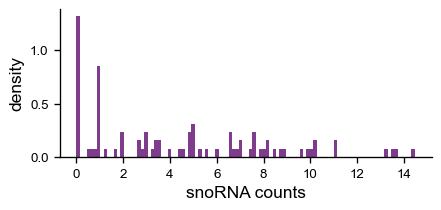

In [31]:
sno_rsem = merged_counts[merged_counts['gene_symbol'].str.contains('sno')].iloc[:, 3:]

# filter down to any sno "genes" that have nonzero reads in any samples
fig, ax = plt.subplots(1, figsize = (5, 2))
plt.hist(sno_rsem.loc[(sno_rsem != 0).any(axis = 1)].sum(axis = 0), bins = 100, density = True);
ax.set_xlabel('snoRNA counts')
ax.set_ylabel('density')
sns.despine(ax = ax)
fig.savefig('images/cwas/tpms-snorna-counts.png', bbox_inches = 'tight')

Some of those values are definitely a little higher than I'd like, but it is what it is. I don't know enough to create some filter.

## PCA plot

In [32]:
tpm_dict = {'log_1p': np.log1p(merged_tpms.iloc[:, 3:]),
            'log_1p_protein': np.log1p(merged_tpms_protein_coding.iloc[:, 3:])}

In [33]:
# normalize for PCA
pca_dict = {}
pca_models = {}
for label, matrix in tpm_dict.items():
    norm_matrix = preprocessing.StandardScaler().fit_transform(matrix.T)
    pca = decomposition.PCA(n_components=min(norm_matrix.shape[0] - 1, norm_matrix.shape[1]), random_state=0)
    
    # store the model
    pca_models[label] = pca
    
    # transform the data, then store the PC results
    pca_transformed_data = pca.fit_transform(norm_matrix)
    
    pca_tpm_df = pd.DataFrame(pca_transformed_data)
    pca_tpm_df.columns = ['PC' + str(i) for i in range(1, len(pca_tpm_df.columns) + 1)]
    pca_tpm_df.index = merged_tpms.columns[3:]
    
    pca_dict[label] = pca_tpm_df

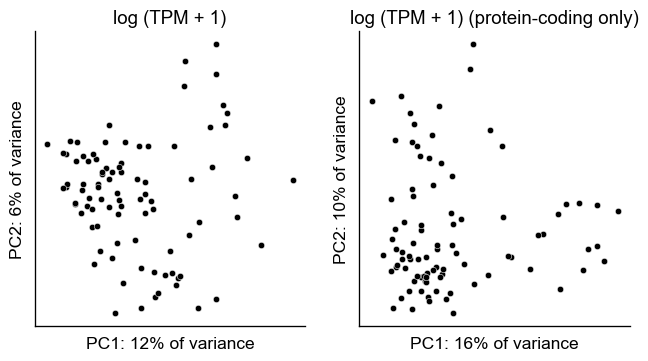

In [34]:
tpm_fig, tpm_axes = plt.subplots(1, 2, figsize = (8, 4))
for i, label in enumerate(['log_1p', 'log_1p_protein']):
    
    data = pca_dict[label][['PC1', 'PC2']].copy()
    
    # plot data
    sns.scatterplot(x = 'PC1', y = 'PC2', data = data, ax = tpm_axes[i], color = 'black')
    
    tpm_axes[i].set_xticklabels([])
    tpm_axes[i].set_yticklabels([])
    tpm_axes[i].tick_params(axis='both', which='both', length = 0)
    
    pca_results = pca_models[label]
    tpm_axes[i].set_xlabel('PC1: {:.0f}% of variance'.format(pca_results.explained_variance_ratio_[0]*100))
    tpm_axes[i].set_ylabel('PC2: {:.0f}% of variance'.format(pca_results.explained_variance_ratio_[1]*100))
    tpm_axes[i].set_title(['log (TPM + 1)', 'log (TPM + 1) (protein-coding only)', 'log (TPM + 1) (hvg)'][i])
    
    sns.despine(bottom = False, left = False)


Obviously, this tells us nothing up front.

## House keeping genes

Another metric we can use is the count of house-keeping genes.

In [35]:
housekeeping = ['ACTB', 'GAPDH', 'TBP', 'UBC', 'RPS18']
housekeeping_counts = merged_counts[merged_counts['gene_symbol'].isin(housekeeping)].set_index('gene_symbol').iloc[:, 2:]
housekeeping_counts_norm = stats.zscore(housekeeping_counts, axis = 1)

Let's plot these on a heatmap

In [36]:
housekeeping_counts_norm

sample,PT_02SNWVRF,PT_11XN6CG5,PT_1396H6SD,PT_1EQHANKW,PT_1RH3DTPB,PT_1X6CJ589,PT_1X9YQF9W,PT_21PJ8R0Z,PT_26E4RFYV,PT_2JZNQGTR,PT_2QB9MP9J,PT_2RZN4HR2,PT_2Y7Q85BM,PT_3VNMNFT6,PT_4Y3P2N1P,PT_56ZM694R,PT_5E269C8Z,PT_5FCYBT0S,PT_69AGBVQ5,PT_6DHGCDRP,PT_6WE8JADD,PT_70BK6DFW,PT_7APMD0HG,PT_7BAFX5PZ,PT_7E6A5N3P,PT_81RSHW1D,PT_82D2FJV2,PT_8DFBAQVQ,PT_9A9Q2YB3,PT_9QQ37AWW,PT_9X3MV3GW,PT_A77B7F2F,PT_AGYJR7PZ,PT_AQS8CCAB,PT_ASJZTDRF,PT_ATQMV6B3,PT_B39849MF,PT_C3YC0C9Q,PT_D5BYDHZ9,PT_DCBZYQAX,PT_E3R0MRXN,PT_E6CZS2KF,PT_EXZSSRGH,PT_F0QD1YWQ,PT_F2AFSP66,PT_FZ3XEWEK,PT_GGJ9E0VV,PT_GSWXPFPQ,PT_HA7TBZ1V,PT_HB9JT4G5,PT_HYJB8Y4N,PT_HZ4VWQP5,PT_JBQT2QPG,PT_JD8FVX6G,PT_JYRSHSWJ,PT_K0BJPWY9,PT_K3QMVST1,PT_K579G3KQ,PT_KBVX8B37,PT_M4ETZ912,PT_M8RHAK5K,PT_MK375DCF,PT_NK39AFPG,PT_P111JVHP,PT_PDYCQB6P,PT_PFRE83H3,PT_PV869ZYE,PT_Q50YZ2T5,PT_QF2A2F08,PT_QH23VVKW,PT_R94DDN50,PT_RVTVP55V,PT_SBS3N6ZT,PT_SDPQ63J1,PT_SV8ETF29,PT_TTHE7B08,PT_V3BXBVVV,PT_V65ESGCE,PT_VVVS471N,PT_W6AVZF18,PT_WWRAC6EH,PT_X8N7GE8X,PT_XPTE7785,PT_YGW6KQHQ,PT_YMDFCE4V,PT_YS31MFW0,PT_Z4S0193A,PT_ZK8Z4WAK,PT_ZT2NW6WA
gene_symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ACTB,-0.051310,1.419095,-0.275998,-0.759972,0.790557,-0.701154,-0.750639,0.113127,-0.492113,0.009577,2.074255,0.940911,-1.215588,-0.713768,1.733806,-0.202277,0.168326,-0.694682,-0.352029,1.019802,2.649434,0.591919,-0.023868,0.025716,-0.724659,0.431261,-0.349796,-0.198579,-0.699841,-0.328587,-0.166072,-0.233537,-0.571863,-0.595000,0.340217,0.112874,-1.009619,-0.073453,-0.777123,0.158618,-0.413146,-0.462526,0.143064,0.399459,0.258251,-0.236403,2.241950,1.944135,-1.007859,3.209140,1.270705,-0.635240,-0.585806,-1.042190,-0.246326,1.827918,-0.967331,-0.218751,-1.279287,-1.422609,0.113937,-0.298950,0.720366,2.274148,0.149282,-0.835062,-0.046388,-0.880480,-1.155299,1.325557,-1.529566,-0.253094,0.302360,0.094942,-0.596666,0.496543,-1.179051,-0.436189,-0.107132,2.020532,-1.378960,-0.367123,-1.539621,-0.794962,1.930497,-0.436434,0.163621,-0.561581,-0.590342
GAPDH,0.123025,1.751855,-0.605048,0.407888,-0.590070,-0.566164,-0.269880,-0.450232,0.076134,-0.116796,1.181047,0.425375,-0.729088,-0.433191,0.723085,-0.562709,0.461319,-0.790581,-0.164804,0.523835,6.221660,1.049172,0.249478,-0.583060,-0.575859,0.434340,-0.534286,0.088224,-0.583828,0.757361,0.390801,-0.341458,0.097448,-0.323792,-0.020692,-0.129373,-0.670428,-0.369824,-0.754149,-0.342993,0.113239,-0.644941,0.025773,0.160181,0.169887,-0.653002,1.389435,0.639367,-0.837818,1.570507,0.079014,-0.604325,-0.531552,-0.763171,-0.413080,1.132705,-0.787653,-0.091692,-0.999689,-1.014666,-0.259131,-0.246216,1.671075,2.846032,-0.526274,-0.671293,-0.306853,-0.139611,-0.749491,0.373468,-1.052925,-0.315006,0.398435,1.387466,-0.650217,-0.318077,-0.908240,-0.194419,-0.384899,0.302905,-0.954420,-0.641866,-1.033004,-0.362195,1.943830,0.044398,-0.346262,-0.550513,-0.748963
TBP,-0.215752,-0.102675,-0.097291,-0.264214,0.021171,-0.151137,-0.549599,-0.328830,0.204249,-0.463445,1.792714,0.591942,-1.567294,0.091171,2.611178,0.731942,0.128864,-0.204983,0.112710,0.344249,2.961555,0.484249,-0.054214,0.015787,-0.253445,1.835791,-0.048829,0.053479,0.317326,0.058864,-0.452676,-0.043444,-0.102675,-0.377291,-0.641138,0.301172,-1.529602,-0.253445,-0.264214,-0.479599,-1.120370,-0.011137,0.285018,-0.468830,-0.194214,-0.371907,2.670409,0.392711,-0.894216,3.876565,2.148100,-0.560369,-0.151137,-1.082678,-0.167291,1.216559,-0.678830,-0.054214,-1.610371,-1.658833,0.484249,-0.274983,0.080402,1.308098,0.279633,-0.242676,-0.274983,0.188095,-1.179601,0.225787,-1.879603,0.441172,0.139633,0.247326,-0.544215,-0.038060,-1.491909,0.285018,0.198864,-0.134983,-1.691141,-0.145752,-1.825756,-0.598061,1.588098,-0.458061,0.274249,0.053479,-0.791908
UBC,-0.028813,1.386068,-0.448400,-0.410503,-0.058557,-0.231737,-0.059614,-0.203955,-0.419562,-0.163944,1.668863,0.599436,-0.894259,-0.388912,0.569088,-0.446739,-0.294244,-0.489468,-0.174966,1.586878,3.415609,1.534336,-0.281109,-0.219356,-0.631696

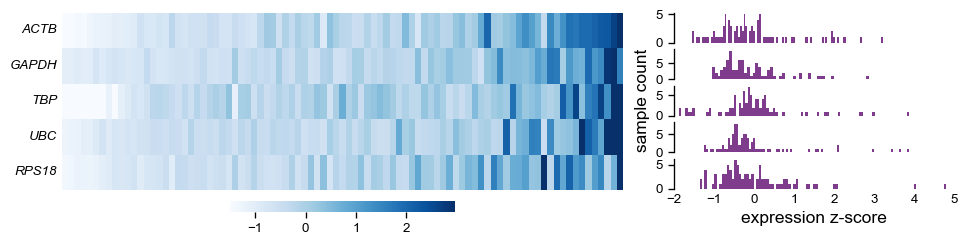

In [37]:
# define a rough order
sample_order = housekeeping_counts_norm.mean(axis = 0).sort_values().index

# make the figure and gridspec
fig = plt.figure(figsize=(12, 3))
gs = fig.add_gridspec(5, 2, width_ratios = [2, 1], wspace = 0.12)

# plot the heatmap
heatmap_ax = fig.add_subplot(gs[:, 0])

sns.heatmap(housekeeping_counts_norm.loc[:, sample_order], cmap="Blues", robust=True, 
            ax = heatmap_ax, cbar_kws={"orientation": "horizontal", "pad":0.05, 'shrink': 0.4})
heatmap_ax.set_yticklabels(housekeeping, rotation = 0, ha = 'right', fontstyle = 'italic')
heatmap_ax.tick_params(which = 'both', length = 0)
heatmap_ax.set_xticklabels([])
heatmap_ax.set_ylabel('')
heatmap_ax.set_xlabel('')

gene_gs = matplotlib.gridspec.GridSpecFromSubplotSpec(6, 1, gs[:, 1], height_ratios = [1] * 5 + [1.3])
for i, g in enumerate(housekeeping):
    ax = fig.add_subplot(gene_gs[i])
    ax.hist(housekeeping_counts_norm.loc[g, :], bins = 100)
    sns.despine(ax = ax, bottom = True)
    ax.set_xlim([-2, 5])
    if i != 4:
        ax.get_xaxis().set_visible(False)
        
    else:
        ax.tick_params(axis = 'x', length = 0)
        ax.set_xlabel('expression z-score')
        
    if i == 2:
        ax.set_ylabel('sample count')
        
fig.savefig('images/cwas/housekeeping-expression.png', bbox_inches = 'tight')

We can try arbitrarily removing a subset of samples if they exceed 2.5 stds of housekeeping expression in 3 housekeeping genes.

In [38]:
percentiles = np.percentile(housekeeping_counts_norm, [95], axis = 1).reshape(-1, 1)
sample_filter = np.greater(housekeeping_counts_norm, percentiles)
removed_samples = sample_filter.loc[:, sample_filter.sum(axis = 0) >= 3]
removed_samples

sample,PT_6WE8JADD,PT_HB9JT4G5,PT_P111JVHP
gene_symbol,,,
ACTB,True,True,True
GAPDH,True,False,True
TBP,True,True,False
UBC,True,True,True
RPS18,False,True,False


In [39]:
removed_samples = removed_samples.columns

Out of curiosity, how does this look on a PCA plot?

In [40]:
housekeeping_mean = housekeeping_counts_norm.mean(axis = 0)

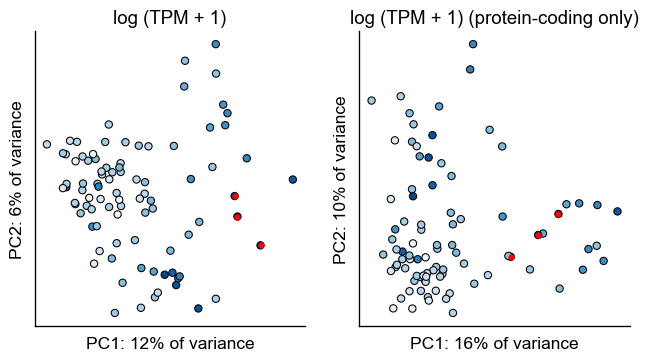

In [41]:
tpm_fig, tpm_axes = plt.subplots(1, 2, figsize = (8, 4))

norm = matplotlib.colors.Normalize(vmin=-1.5, vmax=2)
for i, label in enumerate(['log_1p', 'log_1p_protein']):
    
    data = pca_dict[label][['PC1', 'PC2']].copy()
    
    # add in housekeeping data
    data['housekeeping'] = housekeeping_mean.loc[data.index]
    
    # plot data
    points = tpm_axes[i].scatter(data['PC1'], data['PC2'], c=data['housekeeping'],
                                 cmap=plt.get_cmap('Blues'), norm = norm, edgecolor = 'black', s = 30)
    
    removed = data.loc[removed_samples]
    points = tpm_axes[i].scatter(removed['PC1'], removed['PC2'], c = 'red', edgecolor = None, s = 15)
    
    tpm_axes[i].set_xticklabels([])
    tpm_axes[i].set_yticklabels([])
    tpm_axes[i].tick_params(axis='both', which='both', length = 0)
    
    pca_results = pca_models[label]
    tpm_axes[i].set_xlabel('PC1: {:.0f}% of variance'.format(pca_results.explained_variance_ratio_[0]*100))
    tpm_axes[i].set_ylabel('PC2: {:.0f}% of variance'.format(pca_results.explained_variance_ratio_[1]*100))
    tpm_axes[i].set_title(['log (TPM + 1)', 'log (TPM + 1) (protein-coding only)', 'log (TPM + 1) (hvg)'][i])
    
    sns.despine(bottom = False, left = False)
    
tpm_fig.savefig('images/cwas/tpm-pca-matrix.png', bbox_inches = 'tight')

I mean... meh, right? Clearly these samples are slight outliers, but I see no reason to believe they're extremely abnormal. I don't see a frank need to remove them. So we keep all 89 samples.

## Adrenal signature

One important component of this analysis is that we have no idea of the underlying purity of these samples. This could be a pretty big problem, as eventually we'll be ranking these samples by expression. If a subset of samples have consistently low purity and these genes are relevant in an adrenal context, then we could get skewed results.

One way to check this is to devise an expression signature that is derived from adrenal-specific genes. This could (theoretically) help us control for these effects downstream. Maybe.

In [42]:
adrenal_genes = pd.read_csv('ref/adrenal-specific-genes.txt', sep='\t', comment = '#')['Gene Name'].tolist()
print(adrenal_genes)

['CYP17A1', 'CHGB', 'CYP11B1', 'STAR', 'HSD3B2', 'AKR1B1', 'CYP21A2', 'NOV', 'FDX1', 'DBH', 'SOAT1', 'MGARP', 'TH', 'AS3MT', 'PNMT', 'VWA5B2', 'MCOLN3', 'ARHGAP36', 'CARTPT', 'CYP11B2', 'KCNK2', 'CHRNA3', 'MC2R', 'SLC18A1', 'MAP3K15', 'PHOX2A', 'RET', 'FAM19A4', 'AP000783.1', 'C18orf42', 'AC015660.1', 'PHOX2B', 'FAM43B', 'DRGX', 'UCP1']


In [43]:
merged_tpms_pc_gsea = merged_tpms_protein_coding.set_index('gene_symbol').iloc[:, 2:]
merged_tpms_pc_gsea.head(2)

,PT_02SNWVRF,PT_11XN6CG5,PT_1396H6SD,PT_1EQHANKW,PT_1RH3DTPB,PT_1X6CJ589,PT_1X9YQF9W,PT_21PJ8R0Z,PT_26E4RFYV,PT_2JZNQGTR,PT_2QB9MP9J,PT_2RZN4HR2,PT_2Y7Q85BM,PT_3VNMNFT6,PT_4Y3P2N1P,PT_56ZM694R,PT_5E269C8Z,PT_5FCYBT0S,PT_69AGBVQ5,PT_6DHGCDRP,PT_6WE8JADD,PT_70BK6DFW,PT_7APMD0HG,PT_7BAFX5PZ,PT_7E6A5N3P,PT_81RSHW1D,PT_82D2FJV2,PT_8DFBAQVQ,PT_9A9Q2YB3,PT_9QQ37AWW,PT_9X3MV3GW,PT_A77B7F2F,PT_AGYJR7PZ,PT_AQS8CCAB,PT_ASJZTDRF,PT_ATQMV6B3,PT_B39849MF,PT_C3YC0C9Q,PT_D5BYDHZ9,PT_DCBZYQAX,PT_E3R0MRXN,PT_E6CZS2KF,PT_EXZSSRGH,PT_F0QD1YWQ,PT_F2AFSP66,PT_FZ3XEWEK,PT_GGJ9E0VV,PT_GSWXPFPQ,PT_HA7TBZ1V,PT_HB9JT4G5,PT_HYJB8Y4N,PT_HZ4VWQP5,PT_JBQT2QPG,PT_JD8FVX6G,PT_JYRSHSWJ,PT_K0BJPWY9,PT_K3QMVST1,PT_K579G3KQ,PT_KBVX8B37,PT_M4ETZ912,PT_M8RHAK5K,PT_MK375DCF,PT_NK39AFPG,PT_P111JVHP,PT_PDYCQB6P,PT_PFRE83H3,PT_PV869ZYE,PT_Q50YZ2T5,PT_QF2A2F08,PT_QH23VVKW,PT_R94DDN50,PT_RVTVP55V,PT_SBS3N6ZT,PT_SDPQ63J1,PT_SV8ETF29,PT_TTHE7B08,PT_V3BXBVVV,PT_V65ESGCE,PT_VVVS471N,PT_W6AVZF18,PT_WWRAC6EH,PT_X8N7GE8X,PT_XPTE7785,PT_YGW6KQHQ,PT_YMDFCE4V,PT_YS31MFW0,PT_Z4S0193A,PT_ZK8Z4WAK,PT_ZT2NW6WA
gene_symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TSPAN6,13.371365,7.458475,16.812866,26.645397,4.260488,12.268498,12.030655,9.01669,22.009318,17.438509,12.494672,12.474228,5.98563,19.234141,12.572486,17.233388,28.389828,15.093672,6.492729,17.001738,7.982832,12.501859,36.167566,12.895066,21.734756,45.031394,18.754089,27.487045,17.248522,11.008326,40.932662,9.659539,8.078493,8.503080,9.462301,32.228893,12.300013,13.597521,22.357115,24.351058,18.937078,21.477597,35.373366,12.298143,15.968089,41.23376,14.762318,22.104827,19.800499,20.090890,16.490749,29.011792,15.849597,17.91214,26.242139,14.925513,20.689594,7.206234,19.938861,25.903271,17.608834,18.658268,18.877963,6.368619,16.580955,10.888372,15.481078,12.115863,8.410188,13.207728,48.682937,56.050621,16.449966,18.001097,15.550149,10.397539,22.228091,7.567005,9.337225,11.745586,15.903369,15.366313,42.228962,23.961827,10.793547,17.017862,16.736601,42.579061,27.269844
TNMD,0.111119,0.000000,0.366221,0.000000,0.277858,0.344782,0.119115,0.00000,0.112868,0.191933,0.143617,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.134166,0.000000,0.000000,0.000000,0.538873,0.000000,0.196871,0.000000,0.000000,0.124612,0.000000,0.232639,0.087599,0.369714,0.079502,0.000000,0.238683,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.101794,0.000000,0.095617,0.00000,0.000000,0.000000,6.192156,0.119234,0.448931,0.346128,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.295326,0.097858,0.426965,0.273499,0.000000,0.136789,0.000000,0.000000,0.000000,0.000000,0.000000,0.308433,0.000000,0.000000,0.422912,0.000000,0.000000,0.000000,0.000000,0.556198,0.000000,0.234345,0.000000,0.000000,0.000000,0.000000,0.106152,0.127387,0.000000


In [44]:
ss = gp.ssgsea(data=merged_tpms_pc_gsea,
                   gene_sets={'adrenal': adrenal_genes},
                   outdir=None,
                   sample_norm_method='rank',
                   no_plot=True,
                   min_size=4)

adrenal_signature = ss.res2d
adrenal_signature.columns = ['sample', 'signature', 'enrichment_score', 'normalized_enrichment_score']

2023-12-21 19:25:49,479 [WARNING] Found duplicated gene names, values averaged by gene names!


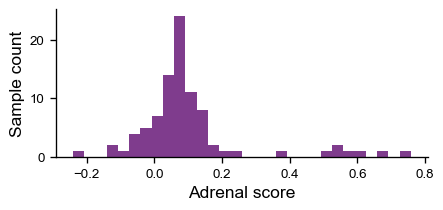

In [45]:
fig, ax = plt.subplots(1, figsize = (5, 2))
plt.hist(adrenal_signature['normalized_enrichment_score'], bins = 30);
ax.set_xlabel('Adrenal score')
ax.set_ylabel('Sample count')
sns.despine()
fig.savefig('images/cwas/adrenal-specific-expression.png', bbox_inches = 'tight')

So there's definitely some variation there. This will be important to keep in mind.